# Constraint Programming (CS 890BR)
## Automating VNF Allocation through Constraing Programming

### Name: Poojan Vyas
### Student ID: 200440326
### Email: pvv747@uregina.ca

***Abstract***: This notebook contains an experimentation of the constraint module that can be used for automating VNF allocation in a network. The notebook describes the necessary methods to build a digital-twin of a network through Python's Networkx package. Additionally, the notebook also explains methods that can be used to solve the VNF allocation problem using constraint programming.

# 1. Defining Methods

## 1.1 Importing Packages

In the following section, I have imported two packages: Networkx and Matplotlib. The networkx package is used for creating a network while the matplotlib package is used for visualizing the package.

In [1]:
# Importing Packages
import networkx as nx
import matplotlib.pyplot as plt

## 1.2 Methods for Creatig Network

The following section contains four methods: create_nodes, create_edges, add_node_attributes and display. The create_nodes methods is used for instantiating the number of nodes that are present in the network like routers, switches etc. The create_edge method is used for connecting nodes with each other that is defining their neighbours. Furthermore, the add_node_attributes method is used for defining the properties of a particular node, for example, defining the compute, storage, RAM and bandwidth of a server rack node. At last, the display method is used for displaying the created digital-twin of the network.

In [2]:
def create_nodes(network_obj, node_list):
    if type(node_list) == list and type(network_obj) == nx.classes.graph.Graph:
        for node in node_list:
            network_obj.add_node(node)
    else:
        if type(node_list) != list:
            raise ValueError("Incorrect type for node_list.")
        elif type(network_obj) != nx.classes.graph.Graph:
            raise ValueError("Incorrect type for network_obj.")
        else:
            raise ValueError("Unexpected error while creating nodes")
            
def create_edge(network_obj, edge_dict):
    if type(edge_dict) == dict and type(network_obj) == nx.classes.graph.Graph:
        for node, node_list in edge_dict.items():
            if type(node_list) == list or type(node_list) == tuple:
                for neighbour_node in node_list:
                    network_obj.add_edge(node, neighbour_node)
            else:
                raise ValueError("Incorrect type for neighbour nodes.")
    else:
        if type(edge_dict) != dict:
            raise ValueError("Incorrect type for edge_dict.")
        elif type(network_obj) != nx.classes.graph.Graph:
            raise ValueError("Incorrect type for network_obj.")
        else:
            raise ValueError("Unexpected error while creating nodes")
            
def add_node_attributes(network_obj, node_att):
    if type(node_att) == dict and type(network_obj) == nx.classes.graph.Graph:
        for node, att_dict in node_att.items():
            if type(att_dict) == dict:
                for key,value in att_dict.items():
                    network_obj.nodes[node][key] = value
            else:
                raise ValueError("Incorrect type for neighbour nodes.")
    else:
        if type(node_att) != dict:
            raise ValueError("Incorrect type for edge_dict.")
        elif type(network_obj) != nx.classes.graph.Graph:
            raise ValueError("Incorrect type for network_obj.")
        else:
            raise ValueError("Unexpected error while creating nodes")
            
def display(network_obj, pos):
    plt.figure(figsize=(20, 10))
    nx.draw_networkx(network_obj, pos, node_size=500, font_color='black')
    plt.show()

## 1.3 Methods for Constraint Module

The following section contains four methods: constraint_satisfaction, objective_function, find_max and vnf_allocation. The constraing_satisfaction method is used to check the statisfiability of the variables on a set of defined constraints. In other words, this methods checks if a VNF's compute, storage, RAM and bandwidth requirements are lesser than the available resources. If a variable value satisfies all the conditions defined in the method, that value is added into a set of all solutions. The objective_function method is used for identifying the optimal solution out of all solutions. The purpose of this method is to utilize the server resources as optimally as possible. Hence, the method checks how much resources a certain VNF might use from all of the server racks and finds the server rack where maximum number of resources are being used using the find_max method. This method can be used for load balancing as well, that is, instead of finding the server rack where maximum number of resources will be used, we can simply find the minimum amount of resources used for load balancing. The selection of which objective to use depends on the needs of an organization. At last, the vnf_allocation method is used to allocate the VNF to the most optimal solution given by the objective_function method.

In [3]:
def constraint_satisfaction(vnf_dict, sr_dict):
    if type(vnf_dict) == dict and type(sr_dict) == dict:
        solution = []
        for sr in sr_dict:
            if vnf_dict["Compute"] <= sr_dict[sr]["Compute"] and vnf_dict["Storage"] <= sr_dict[sr]["Storage"] and vnf_dict["RAM"] <= sr_dict[sr]["RAM"] and vnf_dict["Bandwidth"] <= sr_dict[sr]["Bandwidth"]:
                solution.append(sr)
        return solution
    else:
        if type(vnf_dict) != dict:
            raise ValueError("Incorrect type fro constraint_dict")
        elif type(sr_dict) != dict:
            raise ValueError("Incorrect type fro sr_dict")
        else:
            raise ValueError("Unexpected error while calculating the solution")

def find_max(consumption_dict):
    solution = max(consumption_dict, key=consumption_dict.get)
    pareto_solutions = {solution: consumption_dict[solution]}
    for key in consumption_dict:
        if consumption_dict[solution] == consumption_dict[key] and key != solution:
            pareto_solutions[key] = consumption_dict[key]
    return pareto_solutions
    
def objective_function(network_obj, vnf_dict, solutions):
    if (type(vnf_dict) == dict and (type(solutions) == list or type(solutions) == tuple) and type(network_obj) == nx.classes.graph.Graph):
        module_consumption = {}
        total_consumption = {}
        for sr in solutions:
            compute_consumption = 100*vnf_dict["Compute"]/network_obj.nodes[sr]["Compute"]
            storage_consumption = 100*vnf_dict["Storage"]/network_obj.nodes[sr]["Storage"]
            ram_consumption = 100*vnf_dict["RAM"]/network_obj.nodes[sr]["RAM"]
            bandwidth_consumption = 100*vnf_dict["Bandwidth"]/network_obj.nodes[sr]["Bandwidth"]
            total = (compute_consumption + storage_consumption + ram_consumption + bandwidth_consumption)/4
            module_consumption[sr] = {"Compute": compute_consumption,
                                     "Storage": storage_consumption,
                                     "RAM": ram_consumption,
                                     "Bandwidth": bandwidth_consumption,
                                     "Total": total}
            total_consumption[sr] = total
        pareto_solutions = find_max(total_consumption)
        if len(pareto_solutions) == 1:
            return list(pareto_solutions.keys())[0], module_consumption
        else:
            compute_solutions = {}
            for sr in pareto_solutions:
                compute_solutions[sr] = module_consumption[sr]["Compute"]
            pareto_solutions = find_max(compute_solutions)
            if len(pareto_solutions) == 1:
                return list(pareto_solutions.keys())[0], module_consumption
            else:
                ram_solutions = {}
                for sr in pareto_solutions:
                    ram_solutions[sr] = module_consumption[sr]["RAM"]
                pareto_solutions = find_max(ram_solutions)
                if len(pareto_solutions) == 1:
                    return list(pareto_solutions.keys())[0], module_consumption
                else:
                    bandwidth_solutions = {}
                    for sr in pareto_solutions:
                        bandwidth_solutions[sr] = module_consumption[sr]["Bandwidth"]
                    pareto_solutions = find_max(bandwidth_solutions)
                    if len(pareto_solutions) == 1:
                        return list(pareto_solutions.keys())[0], module_consumption
                    else:
                        storage_solutions = {}
                        for sr in pareto_solutions:
                            storage_solutions[sr] = module_consumption[sr]["Storage"]
                        pareto_solutions = find_max(storage_solutions)
                        if len(pareto_solutions) == 1:
                            return list(pareto_solutions.keys())[0], module_consumption
                        else:
                            return list(pareto_solutions.keys()), module_consumption
    else:
        if type(vnf_dict) != dict:
            raise ValueError("Invalid type for vnf_dict")
        elif type(network_obj) != nx.classes.graph.Graph:
            raise ValueError("Invalid type for network_obj")
        elif type(solutions) != list or type(solutions) != tuple:
            raise ValueError("Invalid type for solutions")
        else:
            raise ValueError("Unexpected error while calculating optimal solution")
            
def vnf_allocation(network_obj, vnf_dict, solution):
    if type(vnf_dict) == dict and type(solution) == str and type(network_obj) ==  nx.classes.graph.Graph:
        if solution in network_obj.nodes:
            network_obj.nodes[solution]["Compute"] -= vnf_dict["Compute"]
            network_obj.nodes[solution]["Storage"] -= vnf_dict["Storage"]
            network_obj.nodes[solution]["RAM"] -= vnf_dict["RAM"]
            network_obj.nodes[solution]["Bandwidth"] -= vnf_dict["Bandwidth"]
            network_obj.nodes[solution]["Active VNFs"].append(vnf_dict["Name"])
            return "VNF Allocated successfully"
        else:
            raise KeyError("Defined solution SR does not exists in the network")
    else:
        if type(vnf_dict) != dict:
            raise ValueError("Invalid type for vnf_dict")
        elif type(solution) != str:
            raise ValueError("Invalid type for solution")
        elif type(network_obj) !=  nx.classes.graph.Graph:
            raise ValueError("Invalid type for network_obj")
        else:
            raise ValueError("Unexpected error while allocating the VNF")

# 2. Creating the Network

The following section creates a digital-twin of a hypothetical network for validating the defined constraint module above. This network is mimiced as a set of three different pods located at different places and connected through a main router. Each pod in the network follows the spine-leaf architecture and consists of a router with two spine switches that are used for handling the traffic that is going to and from the server racks. Additionally, each pods are equiped with three server racks that have four resources (properties) inside them: Compute (in terms of CPU cores), Storage (in GBs), RAM (in GBs) and bandwidth (in Gbps (used for defining the data transfer rate in the rackes)). All of these resources are connected to each other through a Top of the Rack (TOR) switches.

In [4]:
# Create the network object
n = nx.Graph()

In [5]:
# Adds all the nodes in the network
create_nodes(n, ["Main Router", "Router 1", "Router 2", "Router 3",
                "Spine Switch 11", "Spine Switch 12", "Spine Switch 21", "Spine Switch 22",
                "Spine Switch 31", "Spine Switch 32", "TOR 11", "TOR 12", "TOR 13", "TOR 21", "TOR 22", "TOR 23",
                "TOR 31", "TOR 32", "TOR 33", "Server Rack 11", "Server Rack 12", "Server Rack 13",
                "Server Rack 21", "Server Rack 22", "Server Rack 23", "Server Rack 31", "Server Rack 32", "Server Rack 33"])

In [6]:
# Defines the connections between different nodes
edges = {"Main Router": ["Router 1", "Router 2", "Router 3"],
         "Router 1": ["Spine Switch 11", "Spine Switch 12"],
         "Router 2": ["Spine Switch 21", "Spine Switch 22"],
         "Router 3": ["Spine Switch 31", "Spine Switch 32"],
         "Spine Switch 11": ["TOR 11", "TOR 12", "TOR 13"],
         "Spine Switch 12": ["TOR 11", "TOR 12", "TOR 13"],
         "Spine Switch 21": ["TOR 21", "TOR 22", "TOR 23"],
         "Spine Switch 22": ["TOR 21", "TOR 22", "TOR 23"],
         "Spine Switch 31": ["TOR 31", "TOR 32", "TOR 33"],
         "Spine Switch 32": ["TOR 31", "TOR 32", "TOR 33"],
         "TOR 11": ["Server Rack 11"],
         "TOR 12": ["Server Rack 12"],
         "TOR 13": ["Server Rack 13"],
         "TOR 21": ["Server Rack 21"],
         "TOR 22": ["Server Rack 22"],
         "TOR 23": ["Server Rack 23"],
         "TOR 31": ["Server Rack 31"],
         "TOR 32": ["Server Rack 32"],
         "TOR 33": ["Server Rack 33"]}
create_edge(n, edges)

In [7]:
# Defines the resources available inside each server racks
add_node_attributes(n, {"Server Rack 11": {"Compute": 20, "Storage": 2048, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 12": {"Compute": 20, "Storage": 2048, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 13": {"Compute": 10, "Storage": 1024, "RAM": 32, "Bandwidth": 10, "Active VNFs": []},
                       "Server Rack 21": {"Compute": 25, "Storage": 2048, "RAM": 128, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 22": {"Compute": 20, "Storage": 2048, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 23": {"Compute": 10, "Storage": 1024, "RAM": 32, "Bandwidth": 10, "Active VNFs": []},
                       "Server Rack 31": {"Compute": 20, "Storage": 1024, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 32": {"Compute": 10, "Storage": 512, "RAM": 32, "Bandwidth": 10, "Active VNFs": []},
                       "Server Rack 33": {"Compute": 10, "Storage": 512, "RAM": 32, "Bandwidth": 10, "Active VNFs": []}})

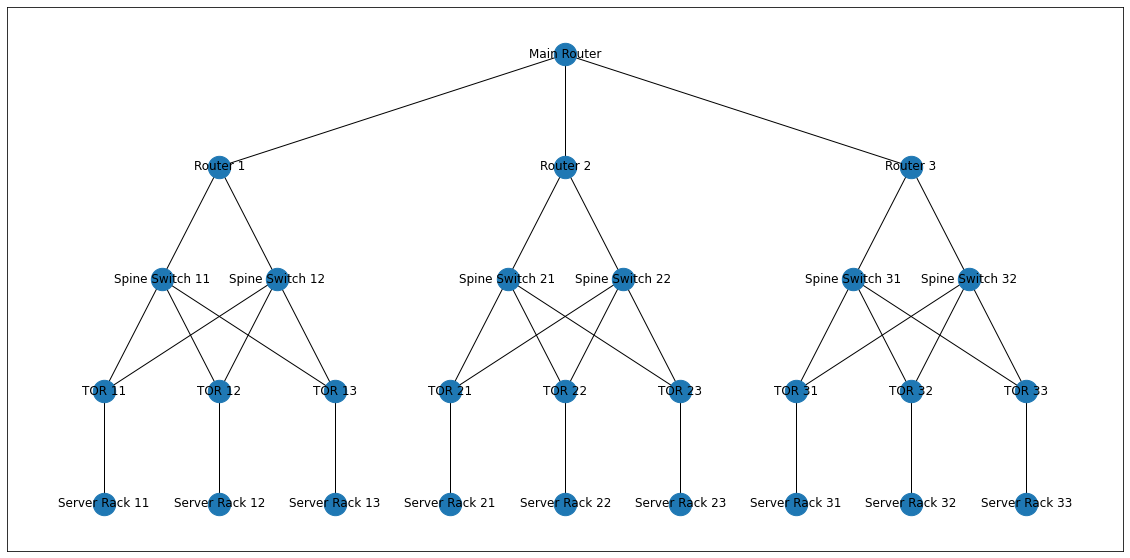

In [8]:
# Display the network
pos_list = [(50, 50), (20, 40), (50, 40), (80, 40), (15, 30), (25, 30), (45, 30), (55, 30), (75, 30), (85, 30), 
            (10, 20), (20, 20), (30, 20), (40, 20),  (50, 20),  (60, 20), (70, 20), (80, 20), (90, 20), (10, 10), 
            (20, 10), (30, 10), (40, 10), (50, 10), (60, 10), (70, 10), (80, 10), (90, 10)]

pos = {}
for i, v in enumerate(list(n.nodes)):
    pos[v] = pos_list[i]
    
display(n, pos)

# 3. Test Cases

## 3.1 Test Case 1 (Adding one VNF in an empty network): 

The following section checks the credibility of the defined constraint module by defining a VNF called "VNF1" with serevral resource requirments and calculates the most optimal solution (server rack) where the VNF will consume the optimal amount of resources.

In [9]:
vnf_dict = {"Name": "VNF1", "Compute": 2, "Storage": 100, "RAM": 8, "Bandwidth": 5}

sr_dict = {}
for node in n.nodes:
    if "Compute" in n.nodes[node] and "Storage" in n.nodes[node] and "RAM" in n.nodes[node] and "Bandwidth" in n.nodes[node]:
        sr_dict[node] = n.nodes[node]

In [10]:
solutions = constraint_satisfaction(vnf_dict, sr_dict)
if len(solutions) > 0:
    print("All possible solutions (server racks) where VNF1 can be allocated:")
    for i, v in enumerate(solutions):
        print(str(i+1) + ") " + str(v))
else:
    print("All server racks are maxed out.")
    print("No solution exists for allocating the defined VNF")

All possible solutions (server racks) where VNF1 can be allocated:
1) Server Rack 11
2) Server Rack 12
3) Server Rack 13
4) Server Rack 21
5) Server Rack 22
6) Server Rack 23
7) Server Rack 31
8) Server Rack 32
9) Server Rack 33


In [11]:
solution, report = objective_function(n, vnf_dict, solutions)
if type(solution) == str:
    print("The most optimal solution (server rack) where VNF1 can be allocated is:", solution)
else:
    print("A set of pareto optimal solutions is:")
    for i, v in enumerate(solution):
        print(str(i+1) + ") " + str(v))
    selected_vnf = int(input("Enter the index of which server rack should be used: "))
    solution = solution[selected_vnf-1]

A set of pareto optimal solutions is:
1) Server Rack 32
2) Server Rack 33
Enter the index of which server rack should be used: 1


In [12]:
print("Resources available in", solution, "before VNF allocation")
print(n.nodes[solution])

Resources available in Server Rack 32 before VNF allocation
{'Compute': 10, 'Storage': 512, 'RAM': 32, 'Bandwidth': 10, 'Active VNFs': []}


In [13]:
vnf_allocation(n, vnf_dict, solution)

'VNF Allocated successfully'

In [14]:
print("Resources available in", solution, "after VNF allocation")
print(n.nodes[solution])

Resources available in Server Rack 32 after VNF allocation
{'Compute': 8, 'Storage': 412, 'RAM': 24, 'Bandwidth': 5, 'Active VNFs': ['VNF1']}


## 3.2 Test Case-2 (Adding several VNF in a network where two pods are occupied): 

The following section checks the credibility of the defined constraint module by defining several VNFs with different resource requirments and calculates optimal solutions (server racks) where all of those VNFs will consume the optimal amount of resources.

In [15]:
# Defines the resources available inside each server racks
add_node_attributes(n, {"Server Rack 11": {"Compute": 20, "Storage": 2048, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 12": {"Compute": 20, "Storage": 2048, "RAM": 64, "Bandwidth": 100, "Active VNFs": []},
                       "Server Rack 13": {"Compute": 10, "Storage": 1024, "RAM": 32, "Bandwidth": 10, "Active VNFs": []},
                       "Server Rack 21": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF1", "VNF2", "VNF3"]},
                       "Server Rack 22": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF4", "VNF5", "VNF6"]},
                       "Server Rack 23": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF7", "VNF8", "VNF9"]},
                       "Server Rack 31": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF10", "VNF11", "VNF12"]},
                       "Server Rack 32": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF13", "VNF14", "VNF15"]},
                       "Server Rack 33": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF16", "VNF17", "VNF18"]}})

In [16]:
multi_vnfs = {"VNF1": {"Name": "VNF1", "Compute": 2, "Storage": 100, "RAM": 8, "Bandwidth": 5},
            "VNF2": {"Name": "VNF2", "Compute": 4, "Storage": 500, "RAM": 16, "Bandwidth": 20},
            "VNF3": {"Name": "VNF3", "Compute": 1, "Storage": 10, "RAM": 4, "Bandwidth": 1},
            "VNF4": {"Name": "VNF4", "Compute": 3, "Storage": 150, "RAM": 8, "Bandwidth": 10},
            "VNF5": {"Name": "VNF5", "Compute": 2, "Storage": 100, "RAM": 8, "Bandwidth": 8}}

In [17]:
for vnf_name, vnf_dict in multi_vnfs.items():
    print("Allocation of", vnf_name)
    print("")
    
    sr_dict = {}
    for node in n.nodes:
        if "Compute" in n.nodes[node] and "Storage" in n.nodes[node] and "RAM" in n.nodes[node] and "Bandwidth" in n.nodes[node]:
            sr_dict[node] = n.nodes[node]
            
    solutions = constraint_satisfaction(vnf_dict, sr_dict)
    if len(solutions) > 0:
        print("All possible solutions (server racks) where VNF1 can be allocated:")
        for i, v in enumerate(solutions):
            print(str(i+1) + ") " + str(v))
    else:
        print("All server racks are maxed out.")
        print("No solution exists for allocating the defined VNF")
    print("")
    
    solution, report = objective_function(n, vnf_dict, solutions)
    if type(solution) == str:
        print("The most optimal solution (server rack) where VNF1 can be allocated is:", solution)
    else:
        print("A set of pareto optimal solutions is:")
        for i, v in enumerate(solution):
            print(str(i+1) + ") " + str(v))
        selected_vnf = int(input("Enter the index of which server rack should be used: "))
        solution = solution[selected_vnf-1]
    print("")
    
    print("Resources available in", solution, "before VNF allocation")
    print(n.nodes[solution])
    print("")
    
    result = vnf_allocation(n, vnf_dict, solution)
    print(result)
    print("")
    
    print("Resources available in", solution, "after VNF allocation")
    print(n.nodes[solution])
    print("")
    print("")

Allocation of VNF1

All possible solutions (server racks) where VNF1 can be allocated:
1) Server Rack 11
2) Server Rack 12
3) Server Rack 13

The most optimal solution (server rack) where VNF1 can be allocated is: Server Rack 13

Resources available in Server Rack 13 before VNF allocation
{'Compute': 10, 'Storage': 1024, 'RAM': 32, 'Bandwidth': 10, 'Active VNFs': []}

VNF Allocated successfully

Resources available in Server Rack 13 after VNF allocation
{'Compute': 8, 'Storage': 924, 'RAM': 24, 'Bandwidth': 5, 'Active VNFs': ['VNF1']}


Allocation of VNF2

All possible solutions (server racks) where VNF1 can be allocated:
1) Server Rack 11
2) Server Rack 12

A set of pareto optimal solutions is:
1) Server Rack 11
2) Server Rack 12
Enter the index of which server rack should be used: 1

Resources available in Server Rack 11 before VNF allocation
{'Compute': 20, 'Storage': 2048, 'RAM': 64, 'Bandwidth': 100, 'Active VNFs': []}

VNF Allocated successfully

Resources available in Server Rac

## 3.3 Test Case-3 (Adding several VNF in a network where all pods are occupied): 

The following section checks the credibility of the defined constraint module by defining a VNF called "VNFX" with serevral resource requirments. The difference in this test case is that, here, all of the server racks are already busy with other VNFs and all of the resources are already occumpied.

In [18]:
# Defines the resources available inside each server racks
add_node_attributes(n, {"Server Rack 11": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF1", "VNF2", "VNF3"]},
                       "Server Rack 12": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF4", "VNF5", "VNF6"]},
                       "Server Rack 13": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF7", "VNF8", "VNF9"]},
                       "Server Rack 21": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF10", "VNF11", "VNF12"]},
                       "Server Rack 22": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF13", "VNF14", "VNF15"]},
                       "Server Rack 23": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF16", "VNF17", "VNF18"]},
                       "Server Rack 31": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF19", "VNF20", "VNF21"]},
                       "Server Rack 32": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF22", "VNF23", "VNF24"]},
                       "Server Rack 33": {"Compute": 0, "Storage": 0, "RAM": 0, "Bandwidth": 0, "Active VNFs": ["VNF25", "VNF26", "VNF27"]}})

In [19]:
vnf_dict = {"Name": "VNFX", "Compute": 2, "Storage": 100, "RAM": 8, "Bandwidth": 5}

sr_dict = {}
for node in n.nodes:
    if "Compute" in n.nodes[node] and "Storage" in n.nodes[node] and "RAM" in n.nodes[node] and "Bandwidth" in n.nodes[node]:
        sr_dict[node] = n.nodes[node]

In [20]:
solutions = constraint_satisfaction(vnf_dict, sr_dict)
if len(solutions) > 0:
    print("All possible solutions (server racks) where VNF1 can be allocated:")
    for i, v in enumerate(solutions):
        print(str(i+1) + ") " + str(v))
else:
    print("All server racks are maxed out.")
    print("No solution exists for allocating the defined VNF")

All server racks are maxed out.
No solution exists for allocating the defined VNF
